<a href="https://colab.research.google.com/github/devan1510/machine-learning-projects/blob/main/SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is Skimlit?
Imagine trying to skim through the literature to find a study relevant to your work.

Sounds like quite the challenge.

# Enter SkimLit!!!
Skimlit uses NLP techniques to classify sentences which appear in sequential order.

# Problem Statement
number of papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature.

# Solution
An NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc) to enable researchers to skim through the literature giving the model the name **SKIMLIT!!!**

# Procedure of the Project

1. Downloading a text dataset (PubMed RCT200k from GitHub)
2. Writing a preprocessing function to prepare our data for modelling
3. Setting up a series of modelling experiments:

b.  Making a baseline (TF-IDF classifier)

a. Deep models with different combinations of: token embeddings, character embeddings, pretrained embeddings, positional embeddings
4. Building our first multimodal model (taking multiple types of data inputs).
5. Comparing the performance of different models on predetermined metrics
6. Making predictions on PubMed abstracts from the internet.

# 1.Download the dataset

In [11]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [12]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


**Comments**: we can see that our dataset is divided into train, validation and test set.

In [16]:
import os

data_directory = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
# check all the filenames in the directory
filenames = [data_directory + filename for filename in os.listdir(data_directory)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

# 2. Preprocess Data

**Data Preprocessing:** data preprocessing is a combination of various techniques to process and convert the data to make it compatible with the selected training model.

In [13]:
# Checkout a sample of the data
with open('pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt', "r") as f:
    lines = f.readlines()[:10]
    for line in lines:
        print(line.strip())

###24293578
OBJECTIVE	To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .
METHODS	A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .
METHODS	Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .
METHODS	Pain was assessed using the visual analog pain scale ( @-@ mm ) .
METHODS	Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .
METHODS	Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP 

In [14]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Read a file and return the lines as a list.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [17]:
# check out the first few lines of the training data
train_lines = get_lines(data_directory+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

**Note:**Reading the lines from the training text file results in a list of strings containing different abstract samples, the sentences in a sample along with the role the sentence plays in the abstract.

The role of each sentence is prefixed at the start of each line separated by a tab (\t) and each sentence finishes with a new line (\n).

Different abstracts are separated by abstract ID's (lines beginning with ###) and newlines (\n).

**Steps:**Let's write a function to perform the following steps:

1.Take a target file of abstract samples.

2.Read the lines in the target file.

3.For each line in the target file:
a.If the line begins with ### mark it as an abstract ID and the beginning of a new abstract.
b.Keep count of the number of lines in a sample.
c.If the line begins with \n mark it as the end of an abstract sample.
d.Keep count of the total lines in a sample.

4.Record the text before the \t as the label of the line.
Record the text after the \t as the text of the line.

**Output**:Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs:
1.**line_number** - the position of the line in the abstract

2.**target** - the role of the line in the abstract

3.**text** - the text of the line in the abstract.

4.**total_lines** - the total lines in an abstract sample
Abstract ID's and newlines should be omitted from the returned preprocessed data.

**Sample Output:**

[{'line_number': 0,

  'target': 'OBJECTIVE',

  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ).',

  'total_lines': 11},
  ...]

In [18]:
# develop a function to preprocess the data to the data into the desired output
def preprocess_text_with_line_numbers(filename):
  """
  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = ""
  abstract_samples = []

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [19]:
# preprocess the train, validation and the test dataset.
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_directory + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_directory + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_directory + "test.txt")
len(train_samples),len(val_samples) ,len(test_samples)


(180040, 30212, 30135)

In [ ]:
# check out a data sample after preprocessing
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [20]:
# convert the train, test and validation data into a dataframe.
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
#distribution of labels
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


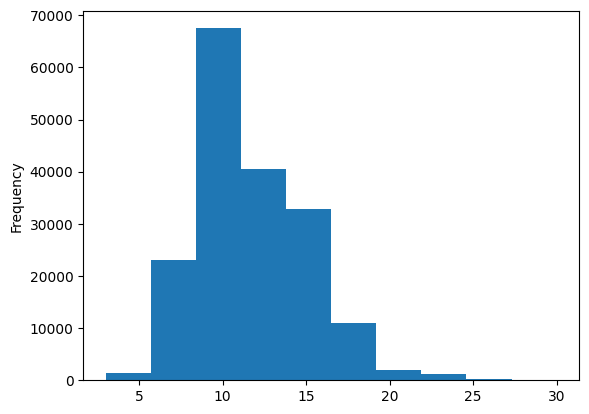

In [ ]:
# distributions of the paragraph lengths
train_df.total_lines.plot.hist(label= 'Distribution of Paragraph Lengths');

In [21]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [ ]:
# check out a sample data
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [37]:
# One hot encode labels to make it compatible with the model
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder()
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))


In [16]:
# check what training labels look like
train_labels_one_hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 180040 stored elements and shape (180040, 5)>

In [23]:
# Extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# get the class names using the label encoder
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

# 3.Modelling Experiments

# 3.1 Setting up a baseline model:TF-IDF and Multinomial Naive Bayes

In [24]:
# create a pipeline for feature extraction and and make classification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
baseline_model = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
baseline_model.fit(X=train_sentences,
            y=train_labels_encoded);

In [25]:
# evaluate the accuracy of the model on the valiadtion dataset
baseline_model.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [26]:
# make predictions
baseline_preds = baseline_model.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [144]:
# calculate the Precision,Accuracy,Recall and F1-Score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

baseline_accuracy = accuracy_score(val_labels_encoded, baseline_preds)
baseline_precision = precision_score(val_labels_encoded, baseline_preds, average='weighted')
baseline_recall = recall_score(val_labels_encoded, baseline_preds, average='weighted')
baseline_f1_score = f1_score(val_labels_encoded, baseline_preds, average='weighted')

print("Evaluation of Model 3 on the below mentioned metrics:\n")
print(f"Accuracy: {baseline_accuracy:.4f}")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall: {baseline_recall:.4f}")
print(f"F1 Score: {baseline_f1_score:.4f}")

Evaluation of Model 3 on the below mentioned metrics:

Accuracy: 0.7218
Precision: 0.7186
Recall: 0.7218
F1 Score: 0.6989


# 3.2 Model 1: Feature extraction with pretrained token embeddings

**Model Structure:**
Inputs (string) ---> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) ---> Layers -> Output (prediction probabilities)

**Note:** in this experiment we are gonna be using feature extraction transfer learning. In other words, taking the patterns a model has learned elsewhere and applying it to our own problem.

**NOTE:** Turn our datasets into a PrefetchDataset of batches, Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.The parameter tf.data.AUTOTUNE will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [38]:
# convert the sparse matrices to dense
train_labels_one_hot = train_labels_one_hot.toarray()
val_labels_one_hot = val_labels_one_hot.toarray()
test_labels_one_hot = test_labels_one_hot.toarray()

In [30]:
# Convert lists/arrays into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [31]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [1]:
# install older versions to resolve any compatibility issues
!pip install tensorflow==2.12.0 tensorflow-hub==0.13.0

In [43]:
import tensorflow as tf
import tensorflow_hub as hub
# Load the USE model from TensorFlow Hub
tf_hub_embedding_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[],
    dtype=tf.string,
    trainable=False,
    name="USE_embedding"
)

# Define feature extractor model using TF Hub layer
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = tf.keras.layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = tf.keras.layers.Dense(5, activation="softmax")(x) # create the output layer
model_1 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)


In [44]:
# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [6]:
# get the summary of the model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_text (InputLayer)     [(None,)]                 0         
                                                                 
 USE_embedding (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________


In [45]:
# Fit feature extractor model
model_1.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=5,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/5
562/562 [==============================] - 12s 17ms/step - loss: 0.9169 - accuracy: 0.6497 - val_loss: 0.7986 - val_accuracy: 0.6912
Epoch 2/5
562/562 [==============================] - 8s 13ms/step - loss: 0.7700 - accuracy: 0.7005 - val_loss: 0.7558 - val_accuracy: 0.6988
Epoch 3/5
562/562 [==============================] - 10s 17ms/step - loss: 0.7522 - accuracy: 0.7124 - val_loss: 0.7375 - val_accuracy: 0.7118
Epoch 4/5
562/562 [==============================] - 10s 17ms/step - loss: 0.7178 - accuracy: 0.7255 - val_loss: 0.7092 - val_accuracy: 0.7324
Epoch 5/5
562/562 [==============================] - 8s 13ms/step - loss: 0.7248 - accuracy: 0.7222 - val_loss: 0.6881 - val_accuracy: 0.7370


In [46]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.6963 - accuracy: 0.7365


[0.696295976638794, 0.7364623546600342]

In [48]:
# Make predictions with feature extraction model
model_1_pred_probs = model_1.predict(valid_dataset)
# Convert the predictions with feature extraction model to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

945/945 [==============================] - 17s 17ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 2])>

In [143]:
# calculate Precision,Accuracy, F1_Score and Recall
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model_1_accuracy = accuracy_score(val_labels_encoded, model_1_preds)
model_1_precision = precision_score(val_labels_encoded, model_1_preds, average='weighted')
model_1_recall = recall_score(val_labels_encoded, model_1_preds, average='weighted')
model_1_f1_score = f1_score(val_labels_encoded, model_1_preds, average='weighted')

print("Evaluation of Model 3 on the below mentioned metrics:\n")
print(f"Accuracy: {model_1_accuracy:.4f}")
print(f"Precision: {model_1_precision:.4f}")
print(f"Recall: {model_1_recall:.4f}")
print(f"F1 Score: {model_1_f1_score:.4f}")

Evaluation of Model 3 on the below mentioned metrics:

Accuracy: 0.7365
Precision: 0.7325
Recall: 0.7365
F1 Score: 0.7309


#  3.3 Model 2: Combining Word Embedding and Character Embedding:

**Steps:**
1. Create a token-level model
2. Create a character-level model
3. Combine the outputs of 1 and 2
4. Build a series of output layers on top of 3
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

**Create an Character Vectorizer Layer**

**Note:**
To figure out how long our vectorized character sequences should be, let's check the distribution of our character sequence lengths.

In [63]:
import random

# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
a random effects spline regression was used to flexibly model the outcomes before and after the dnb and to compare the effects of lidocaine and bupivacaine .

Sentence after embedding:
[ 0.01430405 -0.06126159  0.0276778  -0.05736068 -0.05020624  0.00704701
  0.00533576 -0.02470664  0.03918281  0.07766628  0.05432357  0.02931528
  0.06647909  0.01820589 -0.03388554 -0.0196937  -0.08164603 -0.03410367
 -0.03235246  0.02046092  0.05399418  0.00831931 -0.05433528  0.04715482
 -0.02448169  0.0379147   0.01056223  0.07142126  0.03894243  0.05751605] (truncated output)...

Length of sentence embedding:
512


In [64]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'a   r a n d o m   e f f e c t s   s p l i n e   r e g r e s s i o n   w a s   u s e d   t o   f l e x i b l y   m o d e l   t h e   o u t c o m e s   b e f o r e   a n d   a f t e r   t h e   d n b   a n d   t o   c o m p a r e   t h e   e f f e c t s   o f   l i d o c a i n e   a n d   b u p i v a c a i n e   .'

In [65]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [66]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

In [59]:
import numpy as np

# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [53]:
# Get all keyboard characters for char-level embedding
import string
alphabets = string.ascii_lowercase + string.digits + string.punctuation
alphabets

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [70]:
from tensorflow.keras.layers import TextVectorization

# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabets) + 2 # num characters in alphabet + space + OOV token
character_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
character_vectorizer.adapt(train_chars)

In [72]:
# Check character vocabulary characteristics
char_vocab = character_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


**Create a character embedding layer**

In [76]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = character_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
a   p r o s p e c t i v e   ,   s i n g l e - c e n t e r   t r i a l   w a s   p e r f o r m e d   i n   w h i c h   @   p a t i e n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   u n d e r g o   s i r t   w i t h   c o i l   e m b o l i z a t i o n   o r   t h e   u s e   o f   a n   a r m   .

Length of chars: 128

Vectorized chars:
[[ 5 14  8  7  9 14  2 11  3  4 21  2  9  4  6 18 12  2 11  2  6  3  2  8
   3  8  4  5 12 20  5  9 14  2  8 17  7  8 15  2 10  4  6 20 13  4 11 13
  14  5  3  4  2  6  3  9 20  2  8  2  8  5  6 10  7 15 12 19  5  9  9  4
  18  6  2 10  3  7 16  6 10  2  8 18  7  9  4  8  3 20  4  3 13 11  7  4
  12  2 15 22  7 12  4 25  5  3  4  7  6  7  8  3 13  2 16  9  2  7 17  5
   6  5  8 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [79]:
# Create char embedding layer
character_embedding = tf.keras.layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = character_embedding(character_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
a   p r o s p e c t i v e   ,   s i n g l e - c e n t e r   t r i a l   w a s   p e r f o r m e d   i n   w h i c h   @   p a t i e n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   u n d e r g o   s i r t   w i t h   c o i l   e m b o l i z a t i o n   o r   t h e   u s e   o f   a n   a r m   .

Embedded chars (after vectorization and embedding):
[[[-0.02458252 -0.00696867  0.0227103  ... -0.00656977 -0.00176083
   -0.03576037]
  [-0.02221001  0.02071614  0.03684852 ... -0.03476924  0.01784629
    0.04021097]
  [-0.01147891 -0.00863492 -0.04782769 ...  0.01662934  0.03361206
   -0.03495125]
  ...
  [-0.04795801  0.00083262 -0.01376883 ...  0.00104675 -0.04713291
   -0.01203587]
  [-0.04795801  0.00083262 -0.01376883 ...  0.00104675 -0.04713291
   -0.01203587]
  [-0.04795801  0.00083262 -0.01376883 ...  0.00104675 -0.04713291
   -0.01203587]]]

Character embedding shape: (1, 290, 25)


In [50]:
# 1. Setup token inputs/model
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = tf.keras.layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

In [87]:
from tensorflow.keras import layers

# 2. Setup char inputs/model
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = character_vectorizer(char_inputs)
char_embeddings = character_embedding(char_vectors)
# Ensure that you pass the output of the embedding layer, not the layer itself
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(char_embeddings)  # Use char_embeddings here, not character_embedding
 # Bidirectional-LSTM
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

In [88]:
# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

In [90]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)

In [91]:
# 4. Create output layers(in addition of dropout)
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [92]:
# 5. Construct model with char and token inputs
model_2 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [93]:
# Get summary of token and character model
model_2.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 USE_embedding (KerasLayer)     (None, 512)          256797824   [

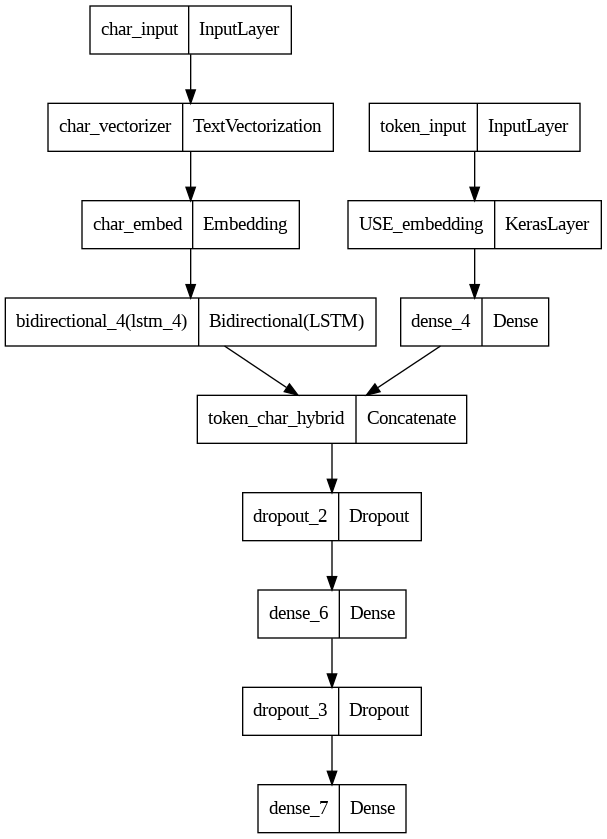

In [94]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_2)

In [95]:
# Compile token char model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

**Comments:**the model requires two inputs, token-level sequences and character-level sequences.

Format:
((token_data, char_data), (label))

**Combining token and character data into a tf.data dataset**

In [96]:
# Combinetoken and character data into a tf.data dataset
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [99]:
# Fit the model on tokens and characters
model_2_history = model_2.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=5,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 155s 275ms/step - loss: 0.9704 - accuracy: 0.6125 - val_loss: 0.7885 - val_accuracy: 0.6968
Epoch 2/5
562/562 [==============================] - 147s 262ms/step - loss: 0.7948 - accuracy: 0.6947 - val_loss: 0.7200 - val_accuracy: 0.7277
Epoch 3/5
562/562 [==============================] - 146s 261ms/step - loss: 0.7715 - accuracy: 0.7029 - val_loss: 0.6942 - val_accuracy: 0.7394
Epoch 4/5
562/562 [==============================] - 152s 271ms/step - loss: 0.7441 - accuracy: 0.7140 - val_loss: 0.6740 - val_accuracy: 0.7513
Epoch 5/5
562/562 [==============================] - 146s 259ms/step - loss: 0.7484 - accuracy: 0.7169 - val_loss: 0.6621 - val_accuracy: 0.7497


In [103]:
# Evaluate on the validation dataset
model_2.evaluate(val_char_token_dataset)


945/945 [==============================] - 59s 63ms/step - loss: 0.6709 - accuracy: 0.7444


In [139]:
# Make predictions using the token-character model hybrid
model_2_predictions_probabilities = model_2.predict(val_char_token_dataset)

945/945 [==============================] - 76s 80ms/step


In [140]:
# Turn prediction probabilities into prediction classes
model_2_predictions = tf.argmax(model_2_predictions_probabilities, axis=1)

In [141]:
# performance evaluation on the metrics:
# 1. Accuracy
# 2. Precision
# 3. Recall
# 4. F1 Score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model_2_accuracy = accuracy_score(val_labels_encoded, model_2_predictions)
model_2_precision = precision_score(val_labels_encoded, model_2_predictions, average='weighted')
model_2_recall = recall_score(val_labels_encoded, model_2_predictions, average='weighted')
model_2_f1_score = f1_score(val_labels_encoded, model_2_predictions, average='weighted')

print("Evaluation of Model 3 on the below mentioned metrics:\n")
print(f"Accuracy: {model_2_accuracy:.4f}")
print(f"Precision: {model_2_precision:.4f}")
print(f"Recall: {model_2_recall:.4f}")
print(f"F1 Score: {model_2_f1_score:.4f}")

Evaluation of Model 3 on the below mentioned metrics:

Accuracy: 0.7489
Precision: 0.7437
Recall: 0.7489
F1 Score: 0.7438


# 3.4 Model 3:Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

**Feature Engineering:**The process of applying your own knowledge to build features as input to a model is called feature engineering.

**Data Preprocessing:** preprocess the data to make it compatible with the 3-Fold Embedding Model.

In [109]:
# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [110]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

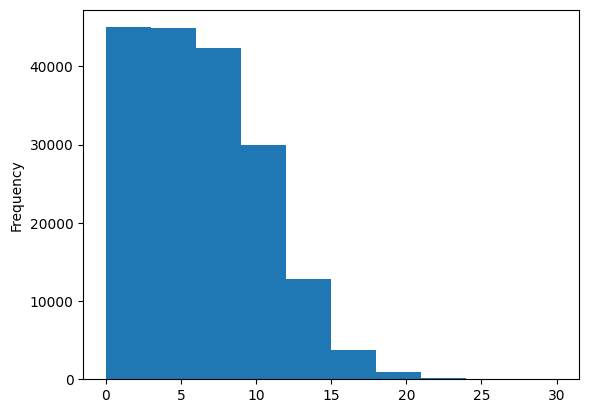

In [111]:
# the distribution of "line_number" column
train_df.line_number.plot.hist()

**Note:**Looking at the distribution of the "line_number" column, it looks like the majority of lines have a position of 15 or less.

Knowing this, let's set the depth parameter of tf.one_hot to 15.

In [112]:
# one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

In [113]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


<Axes: ylabel='Frequency'>

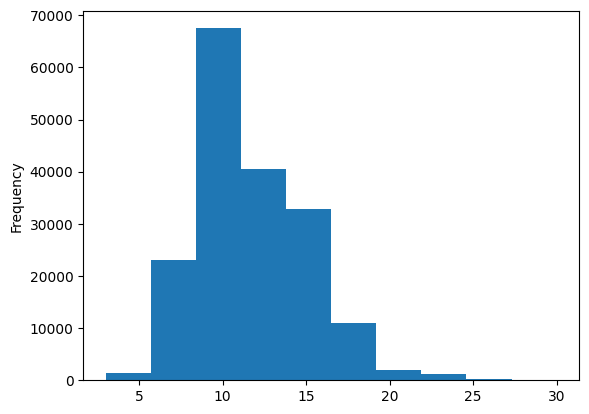

In [114]:
# Check the distribution of total lines
train_df.total_lines.plot.hist()

**Note:**Looking at the distribution of our "total_lines" column, a value of 20 looks like it covers the majority of samples.

In [115]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

**Building a 3-Fold Embedding Model**

**Steps:**
1. Create a token-level model
2. Create a character-level model
3. Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
4. Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
5. Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output
6. Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional 3-fold embedding
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [116]:
# 1. Token inputs ---> token embeddings
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

In [118]:
# 2. Character inputs ---> character embeddings
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = character_vectorizer(char_inputs)
char_embeddings = character_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

In [119]:
# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

In [120]:
# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

In [121]:
# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

In [122]:
# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

In [123]:
# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)


In [124]:
# 8. assemble the model
model_3 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [125]:
# Get a summary of our token, char and positional embedding model
model_3.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 USE_embedding (KerasLayer)     (None, 512)          256797824   ['token_inputs[0][0]']     

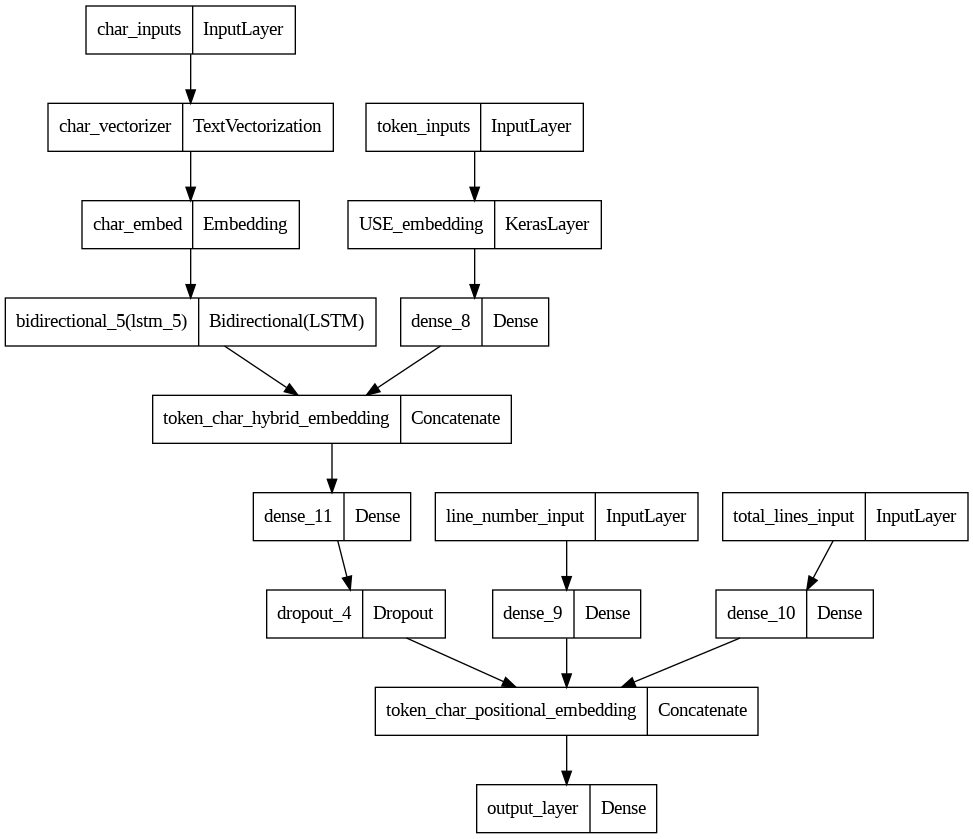

In [126]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_3)

In [127]:
# Compile token, char, positional embedding model
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

**Create tribrid embedding datasets and fit tribrid model:**

Model compiled!

Again, to keep our experiments swift, let's fit on 20,000 examples for 3 epochs.

This time our model requires four feature inputs:

1.Train line numbers one-hot tensor (train_line_numbers_one_hot)

2.Train total lines one-hot tensor (train_total_lines_one_hot)

3.Token-level sequences tensor (train_sentences)

4.Char-level sequences tensor (train_chars)
We can pass these as tuples to our

In [128]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [130]:
# Fit the token, char and positional embedding model
history_model_3 = model_3.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=5,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 164s 282ms/step - loss: 1.0918 - accuracy: 0.7303 - val_loss: 0.9846 - val_accuracy: 0.8049
Epoch 2/5
562/562 [==============================] - 149s 265ms/step - loss: 0.9660 - accuracy: 0.8153 - val_loss: 0.9497 - val_accuracy: 0.8321
Epoch 3/5
562/562 [==============================] - 151s 269ms/step - loss: 0.9504 - accuracy: 0.8235 - val_loss: 0.9383 - val_accuracy: 0.8318
Epoch 4/5
562/562 [==============================] - 154s 274ms/step - loss: 0.9390 - accuracy: 0.8355 - val_loss: 0.9286 - val_accuracy: 0.8358
Epoch 5/5
562/562 [==============================] - 155s 276ms/step - loss: 0.9368 - accuracy: 0.8341 - val_loss: 0.9251 - val_accuracy: 0.8424


In [133]:
# Make predictions with token-char-positional hybrid model
model_3_prediction_probabilities = model_3.predict(val_pos_char_token_dataset, verbose=1)

# Turn prediction probabilities into prediction classes
model_3_predictions = tf.argmax(model_3_prediction_probabilities, axis=1)
model_3_predictions

945/945 [==============================] - 62s 64ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [137]:
# evaluate the performance of the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model_3_accuracy = accuracy_score(val_labels_encoded, model_3_predictions)
model_3_precision = precision_score(val_labels_encoded, model_3_predictions, average='weighted')
model_3_recall = recall_score(val_labels_encoded, model_3_predictions, average='weighted')
model_3_f1_score = f1_score(val_labels_encoded, model_3_predictions, average='weighted')

print("Evaluation of Model 3 on the below mentioned metrics:\n")
print(f"Accuracy: {model_3_accuracy:.4f}")
print(f"Precision: {model_3_precision:.4f}")
print(f"Recall: {model_3_recall:.4f}")
print(f"F1 Score: {model_3_f1_score:.4f}")

Evaluation of Model 3 on the below mentioned metrics:

Accuracy: 0.8426
Precision: 0.8452
Recall: 0.8426
F1 Score: 0.8390


# 4. Comparing the performance of all the model

In [145]:
print("Evaluation Metrics for the Baseline(a TF-IDF and Multinomial Naive Bayes) Model:\n")
print(f"Accuracy: {baseline_accuracy:.4f}")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall: {baseline_recall:.4f}")
print(f"F1 Score: {baseline_f1_score:.4f}")

Evaluation Metrics for the Baseline(a TF-IDF and Multinomial Naive Bayes) Model:

Accuracy: 0.7218
Precision: 0.7186
Recall: 0.7218
F1 Score: 0.6989


In [147]:
print("Evaluation Metrics for the Token Embedding Model:\n")
print(f"Accuracy: {model_1_accuracy:.4f}")
print(f"Precision: {model_1_precision:.4f}")
print(f"Recall: {model_1_recall:.4f}")
print(f"F1 Score: {model_1_f1_score:.4f}")

Evaluation Metrics for the Token Embedding Model:

Accuracy: 0.7365
Precision: 0.7325
Recall: 0.7365
F1 Score: 0.7309


In [148]:
print("Evaluation Metrics for the Token Embedding and Character Embedding Model:\n")
print(f"Accuracy: {model_2_accuracy:.4f}")
print(f"Precision: {model_2_precision:.4f}")
print(f"Recall: {model_2_recall:.4f}")
print(f"F1 Score: {model_2_f1_score:.4f}")

Evaluation Metrics for the Token Embedding and Character Embedding Model:

Accuracy: 0.7489
Precision: 0.7437
Recall: 0.7489
F1 Score: 0.7438


In [149]:
print("Evaluation Metrics for the Token Embedding,Character Embedding and Positional Embedding Model with Transfer Learning:\n")
print(f"Accuracy: {model_3_accuracy:.4f}")
print(f"Precision: {model_3_precision:.4f}")
print(f"Recall: {model_3_recall:.4f}")
print(f"F1 Score: {model_3_f1_score:.4f}")

Evaluation Metrics for the Token Embedding,Character Embedding and Positional Embedding Model with Transfer Learning:

Accuracy: 0.8426
Precision: 0.8452
Recall: 0.8426
F1 Score: 0.8390


**Comments on the Model Comparision:** we can observe that the **3-Fold Embedding Model:Token Embedding,Character Embedding and Positional Embedding Model with Transfer Learning** beats the baseline model and all the other models in all the classification metrics.

**Accuracy: 0.8426**

**Precision: 0.8452**

**Recall: 0.8426**

**F1 Score: 0.8390**

# 5. Evaluate model on test dataset

In [150]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [151]:
# Make predictions on the test dataset
test_pred_probs = model_3.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 60s 63ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 2, 1, 4, 0])>

In [169]:
# Evaluate loaded model test predictions
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_accuracy = accuracy_score(test_labels_encoded, test_preds)
test_precision = precision_score(test_labels_encoded, test_preds, average='weighted')
test_recall = recall_score(test_labels_encoded, test_preds, average='weighted')
test_f1_score = f1_score(test_labels_encoded,test_preds, average='weighted')

print("Evaluation of 3-Fold Embedding Model on the test dataset:\n")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1_score:.4f}")

Evaluation of 3-Fold Embedding Model on the test dataset:

Accuracy: 0.8365
Precision: 0.8384
Recall: 0.8365
F1 Score: 0.8329


# 6. Make Predictions from the Internet Data

**Note:**To really test the performance of the model, test the model's performance on a data extracted from the internet.

**Plan:**
find an RCT abstract from PubMed, preprocess the text so it works with our model, then pass each sequence in the wild abstract through our model to see what label it predicts.

 **Steps:**
search PubMed for RCT's (randomized controlled trials) without abstracts which have been split up (on exploring PubMed you'll notice many of the abstracts are already preformatted into separate sections, this helps dramatically with readability).

In [152]:
import json

# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2025-04-22 16:27:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2025-04-22 16:27:38 (59.8 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

**Comments:**
before we can make a prediction on it, we need to preprocess it just as we have our other sequences.

More specifically, for each abstract, we'll need to:

1.Split it into sentences (lines).

2.Split it into characters.

3.Find the number of each line.

4.Find the total number of lines.

In [153]:
# convert the abstract to a dataframe
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


**parse it using spaCy to turn it from a big chunk of text into sentences.**

In [155]:
# we'll need to parse it using spaCy to turn it from a big chunk of text into sentences.
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd
from spacy.lang.en import English
nlp = English() # setup English sentence parser

# New version of spaCy
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

**count line numbers as well as total lines**

In [156]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

**one-hot encode them with tf.one_hot just like the training dataset**

In [157]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [158]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [159]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

**pass the features to the 3Fold Embedding Model with Transfer Learning and make sequence label predictions**

In [160]:
# Make predictions on sample abstract features
test_abstract_pred_probabilities = model_3.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probabilities

1/1 [==============================] - 2s 2s/step


array([[0.36428964, 0.08234172, 0.02414547, 0.4852924 , 0.04393074],
       [0.06609786, 0.03294873, 0.75802493, 0.08096073, 0.06196772],
       [0.11003918, 0.04712581, 0.6409001 , 0.12532955, 0.07660539],
       [0.10199676, 0.11399393, 0.5722645 , 0.07077564, 0.14096925],
       [0.04683372, 0.08099327, 0.49137506, 0.0416822 , 0.33911577],
       [0.03094513, 0.07892817, 0.67095137, 0.03633041, 0.18284488],
       [0.03099158, 0.23195961, 0.11478933, 0.02418729, 0.59807205],
       [0.01838401, 0.14553861, 0.20147635, 0.0276503 , 0.60695076]],
      dtype=float32)

In [163]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probabilities, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

**visualize each sentence with its predicted label.**

In [164]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [165]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
